Fina Short UEP239 Final Project

## Introduction

In this project I will execute a suitability analysis determining the most suitable ZIP Code Tabulation Area (ZCTA) for recent college graduates to move to. The project focuses on the Boston Metropolitan Area as defined by the boundary of the Boston Region Metropolitan Planning Organization (MPO). The analysis will use the following  indicators to calculate suitability for this demographic:

** Mean housing price/rent payment (where 5=most suitable=lowest rent)
** Age distribution of neighborhood population** (where age closest to 22 and then older from there is best)
** Population density** (where 5=densest = best; we want to replicate a college atmosphere!)
** Euclidean proximity to bus stops **
** Euclidean proximity to train stops **
** Euclidean proximity to farmers markets **


In [56]:
#Import dependencies
import rasterio
from rasterio.plot import show
from rasterio import features

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

import richdem as rd
from scipy import ndimage
from rasterstats import zonal_stats

In [15]:
#Use the provided MA outline with detailed coastline OUTLINE25K_POLY.shp to clip the ZCTAs shapefile tl_2010_25_zcta510.shp into the more detailed outline. 
#This will remove the parts of the coastal ZCTAs that extend into the ocean, allowing for a better match with the Boston Region MPO boundary and making your maps more beautiful. 
#This can easily be done using the clip() function from GeoPandas.

#Extract the outline of the Boston Region MPO from the MPO boundaries shapefile. (This can be easily done using plain old Pandas boolean indexing.)

#Extract all the ZCTAs whose centroid is within the Boston Region MPO boundary.

Importing ZCTA data

<AxesSubplot:>

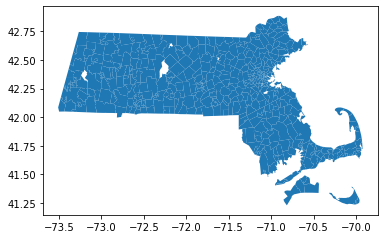

In [11]:
zcta= gpd.read_file("\\Users\\finas\\Documents\\my work\\School work\\Tufts GRAD\\Spring 2021\\UEP239\\uep239-final-project\\project_data\\tl_2010_25_zcta510\\tl_2010_25_zcta510.shp")
zcta.plot()

In [12]:
#check for missing data: no null row values within the dataset columns, although some ZCTAs are clearly missing from the state as we see from the plot
zcta.isnull().sum()

STATEFP10     0
ZCTA5CE10     0
GEOID10       0
CLASSFP10     0
MTFCC10       0
FUNCSTAT10    0
ALAND10       0
AWATER10      0
INTPTLAT10    0
INTPTLON10    0
PARTFLG10     0
geometry      0
dtype: int64

In [52]:
zcta.crs #check crs, we need to transform it to PSG:6491, NAD83 (2011) / Massachusetts Mainland 
zcta = zcta.to_crs("EPSG:6491")
zcta.crs

<Projected CRS: EPSG:6491>
Name: NAD83(2011) / Massachusetts Mainland
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Massachusetts onshore - counties of Barnstable; Berkshire; Bristol; Essex; Franklin; Hampden; Hampshire; Middlesex; Norfolk; Plymouth; Suffolk; Worcester.
- bounds: (-73.5, 41.46, -69.86, 42.89)
Coordinate Operation:
- name: SPCS83 Massachusetts Mainland zone (meters)
- method: Lambert Conic Conformal (2SP)
Datum: NAD83 (National Spatial Reference System 2011)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [ ]:
Importing MA boundary

In [53]:
mpo= gpd.read_file("\\Users\\finas\\Documents\\my work\\School work\\Tufts GRAD\\Spring 2021\\UEP239\\uep239-final-project\\project_data\\MPO_Boundaries\\MPO_Boundaries.shp")
#first things first check coordinate system
mpo.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [54]:
#change to PSG:6491, NAD83 (2011) / Massachusetts Mainland 
mpo = mpo.to_crs("EPSG:6491")
mpo.crs

<Projected CRS: EPSG:6491>
Name: NAD83(2011) / Massachusetts Mainland
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Massachusetts onshore - counties of Barnstable; Berkshire; Bristol; Essex; Franklin; Hampden; Hampshire; Middlesex; Norfolk; Plymouth; Suffolk; Worcester.
- bounds: (-73.5, 41.46, -69.86, 42.89)
Coordinate Operation:
- name: SPCS83 Massachusetts Mainland zone (meters)
- method: Lambert Conic Conformal (2SP)
Datum: NAD83 (National Spatial Reference System 2011)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [65]:
#extract boston region from MPO
boston_mpo_polygon = mpo.geometry[mpo.MPO == 'Boston Region'].iat[0]
boston_mpo_polygon.crs


AttributeError: 'MultiPolygon' object has no attribute 'crs'

In [ ]:
#Clip Boston ZCTAs to the more detailed MA boundary, use geopandas.clip()


Data for Demographic & Social Indicators

In [ ]:
#indicator for age and sex, csv format
ACSST5Y2019.S0101

In [8]:
#read in bus stops file
buspoints= gpd.read_file("\\Users\\finas\\Documents\\my work\\School work\\Tufts GRAD\\Spring 2021\\UEP239\\uep239-final-project\\project_data\\MBTA_Bus_Stops\\MBTA_Bus_Stops.shp")
buspoints.head(8)

,OBJECTID,STOP_ID,STOP_NAME,TOWN,TOWN_ID,geometry
0,1,3077,Gallivan Blvd @ opp Marsh St,BOSTON,35,POINT (237120.669 892643.408)
1,2,841,Lagrange St @ Virgil Rd,BOSTON,35,POINT (227915.195 892644.017)
2,3,446,Norfolk St @ Nelson St,BOSTON,35,POINT (234385.661 892644.944)
3,4,847,Lagrange St opp Virgil St,BOSTON,35,POINT (227912.601 892650.156)
4,5,3079,Adams St @ Minot St,BOSTON,35,POINT (236644.812 892651.990)
5,6,8687,Adams St @ Minot St,BOSTON,35,POINT (236649.767 892672.199)
6,7,808,Centre St opp Bellevue st,BOSTON,35,POINT (228299.467 892674.321)
7,8,33076,Gallivan Blvd @ Hallet St,BOSTON,35,POINT (237367.877 892703.008)


<AxesSubplot:>

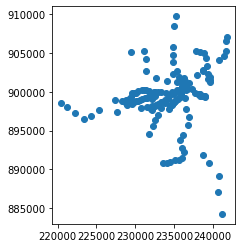

In [24]:
#read in T stops file
tpoints= gpd.read_file("\\Users\\finas\\Documents\\my work\\School work\\Tufts GRAD\\Spring 2021\\UEP239\\uep239-final-project\\project_data\\MBTA_NODE\\MBTA_NODE.shp")
tpoints.head(8)
tpoints.plot()

In [21]:
#plot t stops per line
stopcount = tpoints['STATION'].groupby(tpoints['LINE']).agg(['count','nunique' ])

p = sns.barplot(y="STATION", x="LINE", data=stopcount)
p.set_xticklabels(p.get_xticklabels(),rotation=30)

ValueError: Could not interpret input 'LINE'

In [64]:
#read in farmers markets
markets = gpd.read_file("\\Users\\finas\\Documents\\my work\\School work\\Tufts GRAD\\Spring 2021\\UEP239\\uep239-final-project\\project_data\\FARMERSMARKETS_PT\\FARMERSMARKETS_PT.shp")
markets_raster = features.rasterize(markets['geometry'], out_shape=shape, fill=1, transform=transform, default_value=0)

NameError: name 'shape' is not defined

#For each chosen indicator:
#If applicable, visualize any spatial data the indicator is based on. (For example, the locations of certain POIs.)

//Summarize the indicator values (like population density) for each ZCTA in the study area.//


Produce a choropleth map visualizing the indicator values and produce a ZCTA ranking based on the indicator values, reporting the highest and lowest ranking ZCTAs.



#Convert the indicator values into a suitability or vulnerability index or score. This can be done in two ways:


#Reclassify the indicator values based on classes of your choice into a five-point (or ten-point) score.

#Normalize the indicator values into a suitability or vulnerability index ranging from zero to one.